## Coastline Evolution Model

The Coastline Evolution Model (CEM) addresses predominately sandy, wave-dominated coastlines on time-scales ranging from years to millenia and on spatial scales ranging from kilometers to hundreds of kilometers. Shoreline evolution results from gradients in wave-driven alongshore sediment transport. 
At its most basic level, the model follows the standard 'one-line' modeling approach, where the cross-shore dimension is collapsed into a single data point. However, the model allows the planview shoreline to take on arbitrary local orientations, and even fold back upon itself, as complex shapes such as capes and spits form under some wave climates (distributions of wave influences from different approach angles). So the model works on a 2D grid.

The model has been used to represent varying geology underlying a sandy coastline and shoreface in a simplified manner and enables the simulation of coastline evolution when sediment supply from an eroding shoreface may be constrained. CEM also supports the simulation of human manipulations to coastline evolution through beach nourishment or hard structures.

CEM authors & developers: Andrew Ashton, Brad Murray, Jordan Slot, Jaap Nienhuis and others.

This version is adapted from a CSDMS teaching notebook, listed below. 
It has been created by Irina Overeem, October 2019 for a Sedimentary Modeling course.

* Link to this notebook: https://github.com/csdms/pymt/blob/master/notebooks/cem.ipynb
* Install command: `$ conda install notebook pymt_cem`
* Download local copy of notebook:

  `$ curl -O https://raw.githubusercontent.com/csdms/pymt/master/notebooks/cem.ipynb`

### Key References

Ashton, A.D., Murray, B., Arnault, O. 2001. Formation of coastline features by large-scale instabilities induced by high-angle waves, Nature 414.

Ashton, A. D., and A. B. Murray (2006), High-angle wave instability and emergent shoreline shapes: 1. Modeling of sand waves, flying spits, and capes, J. Geophys. Res., 111, F04011, doi:10.1029/2005JF000422.


### Links
* [CEM source code](https://github.com/csdms/cem-old/tree/mcflugen/add-function-pointers): Look at the files that have *deltas* in their name.
* [CEM description on CSDMS](http://csdms.colorado.edu/wiki/Model_help:CEM): Detailed information on the CEM model.

### Interacting with the Coastline Evolution Model BMI using Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Some magic that allows us to view images within the notebook.
%matplotlib inline

Import the `Cem` class. In Python, a model with a Basic Model Interface (BMI) will have no arguments for its constructor. Note that although the class has been instantiated, it's not yet ready to be run. We'll get to that later!

In [2]:
import pymt.models
cem = pymt.models.Cem()

➡ models: Avulsion, Plume, Sedflux3D, Subside, FrostNumber, Ku, Hydrotrend, Cem, Waves


Even though we can't run our waves model yet, we can still get some information about it. Some things we can do with our model are to get help, to get the names of the input variables or output variables.

In [3]:
help(cem)

Help on Cem in module pymt.framework.bmi_bridge object:

class Cem(BmiCap)
 |  Basic Model Interface for cem.
 |  
 |  The Coastline Evolution Model addresses predominately sandy, wave-
 |  dominated coastlines on time scales ranging from years to millenia and
 |  on spatial scales ranging from kilometers to hundreds of kilometers.
 |  CEM simulates planview coastline evolution due to wave-driven
 |  alongshore sediment transport. This model can incorporate river
 |  influence and transport fluvial sediment from one or more point
 |  sources along the coastline.
 |  
 |  Author:
 |  - A. Brad Murray
 |  Version: 0.1.1
 |  License: MIT
 |  DOI: 10.1594/IEDA/100100
 |  URL: http://csdms.colorado.edu/wiki/Model_help:CEM
 |  
 |  
 |  
 |  Parameters
 |  ----------
 |  grid_spacing : float, optional
 |      Grid resolution in cross and along-shore direction [default=1000.0 m]
 |  number_of_cols : int, optional
 |      Number of columns in the computational grid [default=1000 -]
 |  number_

In [4]:
cem.input_var_names

('sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity',
 'land_surface_water_sediment~bedload__mass_flow_rate',
 'sea_surface_water_wave__period',
 'sea_surface_water_wave__height',
 'land_surface__elevation',
 'model__time_step')

In [5]:
cem.output_var_names

('basin_outlet~coastal_center__x_coordinate',
 'basin_outlet~coastal_water_sediment~bedload__mass_flow_rate',
 'land_surface__elevation',
 'sea_water__depth',
 'basin_outlet~coastal_center__y_coordinate',
 'model__time_step')

We can also get information about specific variables. Here we'll look at some info about wave direction. This is the main input of the Cem model. Notice that BMI components always use [CSDMS standard names](http://csdms.colorado.edu/wiki/CSDMS_Standard_Names). The CSDMS Standard Name for wave angle is,

    "sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity"

Quite a mouthful, I know. With that name we can get information about that variable and the grid that it is on (it's actually not a one).

In [6]:
angle_name = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'

print("Data type: %s" % cem.get_var_type(angle_name))
print("Units: %s" % cem.get_var_units(angle_name))
print("Grid id: %d" % cem.get_var_grid(angle_name))
print("Number of elements in grid: %d" % cem.get_grid_number_of_nodes(0))
print("Type of grid: %s" % cem.get_grid_type(0))

Data type: float64
Units: radians
Grid id: 0
Number of elements in grid: 1
Type of grid: scalar


First we initialize the model with the BMI **initialize** method. Normally we would pass it a string that represents the name of an input file. For this example we'll pass **None**, which tells Cem to use some defaults.

In [7]:
args = cem.setup(number_of_rows=100, number_of_cols=200, grid_spacing=200.)

In [8]:
cem.initialize(*args)

Before running the model, let's set a couple input parameters. These two parameters represent the wave height and wave period of the incoming waves to the coastline.

In [9]:
cem.set_value("sea_surface_water_wave__height", 1.5)
cem.set_value("sea_surface_water_wave__period", 7.)
cem.set_value("sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity", 0. * np.pi / 180.)

array([ 0.])

## Assignment 1

Let's think about the wave conditions that are the input to this CEM model run. For both assignment 1 and 2 it will help to look theory up in the paper by Ashton & Murray 2001, and/or Ashton et al, 2006.

How do wave height and wave period determine sediment transport?
The relationship between sediment transport and wave height and period is non-linear. What are the implications of this non-linearity for the impact of lots of small ocean storms versus a few extreme storms with much higher wave height?

In [10]:
# list your answers here

## Assignment 2

The other important part of the wave conditions that is input to CEM model is under what angle the waves approach the shore. It will help to read the paper by Ashton & Murray 2001, and the longer version by Ashton et al, 2006.
Explain why incoming wave angle is an important control?


In [11]:
# discuss wave angle here

The CEM model operates on a grid, consisting of a number of rows and colums with values. 
The main output variable for this model is *water depth*, or bathymetry. In this case, the CSDMS Standard Name is much shorter:

    "sea_water__depth"

First we find out which of Cem's grids contains water depth. 

In [12]:
grid_id = cem.get_var_grid('sea_water__depth')

With the *grid_id*, we can now get information about the grid. For instance, the number of dimension and the type of grid. This grid happens to be *uniform rectilinear*. If you were to look at the "grid" types for wave height and period, you would see that they aren't on grids at all but instead are scalars, or single values.

In [13]:
grid_type = cem.get_grid_type(grid_id)
grid_rank = cem.get_grid_ndim(grid_id)
print('Type of grid: %s (%dD)' % (grid_type, grid_rank))

Type of grid: uniform_rectilinear (2D)


Because this grid is uniform rectilinear, it is described by a set of BMI methods that are only available for grids of this type. These methods include:
* get_grid_shape
* get_grid_spacing
* get_grid_origin

In [14]:
spacing = np.empty((grid_rank, ), dtype=float)

shape = cem.get_grid_shape(grid_id)
cem.get_grid_spacing(grid_id, out=spacing)

print('The grid has %d rows and %d columns' % (shape[0], shape[1]))
print('The spacing between rows is %f m and between columns is %f m' % (spacing[0], spacing[1]))

The grid has 100 rows and 200 columns
The spacing between rows is 200.000000 m and between columns is 200.000000 m


Allocate memory for the water depth grid and get the current values from `cem`.

In [15]:
z = np.empty(shape, dtype=float)
cem.get_value('sea_water__depth', out=z)

array([[ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       ..., 
       [ 22.4,  22.4,  22.4, ...,  22.4,  22.4,  22.4],
       [ 22.6,  22.6,  22.6, ...,  22.6,  22.6,  22.6],
       [ 22.8,  22.8,  22.8, ...,  22.8,  22.8,  22.8]])

Here I define a convenience function for plotting the water depth and making it look pretty. You don't need to worry too much about it's internals for this tutorial. It just saves us some typing later on.

In [16]:
def plot_coast(spacing, z):
    import matplotlib.pyplot as plt
    
    xmin, xmax = 0., z.shape[1] * spacing[0] * 1e-3
    ymin, ymax = 0., z.shape[0] * spacing[1] * 1e-3

    plt.imshow(z, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='ocean')
    plt.colorbar().ax.set_ylabel('Water Depth (m)')
    plt.xlabel('Along shore (km)')
    plt.ylabel('Cross shore (km)')

It generates plots that look like this. We begin with a flat delta (green) and a linear coastline (y = 3 km). The bathymetry drops off linearly to the top of the domain to more than 20 m water depth.

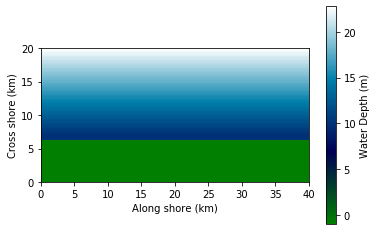

In [17]:
plot_coast(spacing, z)

Right now we have waves coming in but no sediment entering the ocean. To add a sediment source and specify its discharge, we need to figure out where to put it. For now we'll put it on a cell that's next to the ocean.

In [18]:
#Allocate memory for the sediment discharge array 
# and set the bedload sediment flux at the coastal cell to some value.
qs = np.zeros_like(z)
qs[0, 100] = 750

The CSDMS Standard Name for this variable is:

    "land_surface_water_sediment~bedload__mass_flow_rate"

You can get an idea of the units based on the quantity part of the name. "mass_flow_rate" indicates mass per time. You can double-check this with the BMI method function **get_var_units**.

In [19]:
cem.get_var_units('land_surface_water_sediment~bedload__mass_flow_rate')

'kg / s'

## Assignment 3

Here, we are introducing a river mouth of one gridcell of 200 by 200m. And we just have specified a bedload flux of 750 kg/s. Is this a realistic incoming value?
How much water discharge and slope would you possibly need to transport a bedload flux of that magnitude? 

In [20]:
# read in the csv file of bedload measurements in the Rhine River, the Netherlands
# these data were collected over different days over a season in 2004, at nearby locations.
# plot how river discharge controls bedload; Q (x-axis) and Qb (y-axis) data. 
# label both axes


## Assignment 4

The bedload measurements were a combination of very different methods, and taken at different locations (although nearby). The data is quite scattered. But if you would fit a linear regression line through this data,
you would find that the river discharge of the Rhine can be related to its bedload transport as: 
    Qb=0.0163*Q

In [21]:
# extrapolate this relationship and calculate how much river discharge, Q, 
# would be needed to transport the model specification Qb of 1250 kg/s


In [22]:
cem.time_step, cem.time_units, cem.time

(0.2, 'd', 0.0)

Set the bedload flux and run the model.

In [23]:
for time in range(3000):
    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs)
    cem.update_until(time)
    
cem.get_value('sea_water__depth', out=z)

array([[ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       ..., 
       [ 22.4,  22.4,  22.4, ...,  22.4,  22.4,  22.4],
       [ 22.6,  22.6,  22.6, ...,  22.6,  22.6,  22.6],
       [ 22.8,  22.8,  22.8, ...,  22.8,  22.8,  22.8]])

In [24]:
cem.time

2999.0

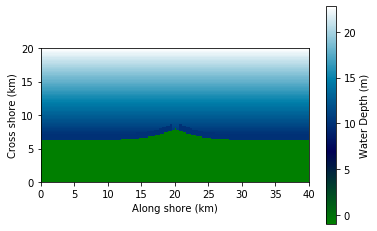

In [25]:
cem.get_value('sea_water__depth', out=z)
plot_coast(spacing, z)

In [26]:
# this code gives you a handle on retrieving the position of the river mouth over time 
val = np.empty((5, ), dtype=float)
cem.get_value("basin_outlet~coastal_center__x_coordinate", val)
val / 100.

array([  7.80000000e+01,   5.00000000e-02,   1.00000000e-01,
         1.50000000e-01,   2.00000000e-01])

In [27]:
print(val)

[  7.80000000e+03   5.00000000e+00   1.00000000e+01   1.50000000e+01
   2.00000000e+01]


## Assignment 5

Describe what the CEM model has simulated in 3000 timesteps. How far has this wave influenced delta prograded? 
Recall the R-factor for fluvial dominance (Nienhuis 2015). What would the R-factor be for this simulated system? (smaller then 1, larger then 1)? Motivate.

In [28]:
# your run description goes here

## Assignment 6

Let's add another sediment source with a different flux and update the model. remember that the Basic Model Interface allows you to update values and then continue a simulation

In [29]:
# introduce a second river here
qs[0, 150] = 1500
for time in range(4000):
    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs)
    cem.update_until(time)
    
cem.get_value('sea_water__depth', out=z)

array([[ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       ..., 
       [ 22.4,  22.4,  22.4, ...,  22.4,  22.4,  22.4],
       [ 22.6,  22.6,  22.6, ...,  22.6,  22.6,  22.6],
       [ 22.8,  22.8,  22.8, ...,  22.8,  22.8,  22.8]])

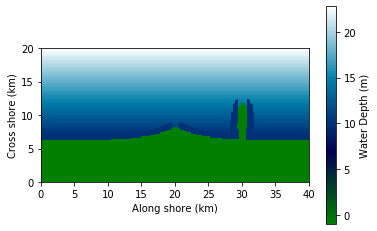

In [30]:
plot_coast(spacing, z)

Here we shut off the sediment supply completely.

In [31]:
qs.fill(0.)
for time in range(4500):
    cem.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qs)
    cem.update_until(time)
    
cem.get_value('sea_water__depth', out=z)

array([[ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       ..., 
       [ 22.4,  22.4,  22.4, ...,  22.4,  22.4,  22.4],
       [ 22.6,  22.6,  22.6, ...,  22.6,  22.6,  22.6],
       [ 22.8,  22.8,  22.8, ...,  22.8,  22.8,  22.8]])

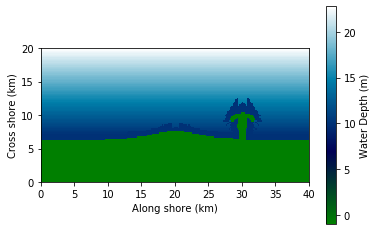

In [32]:
plot_coast(spacing, z)

## Assignment 7
Create a new CEM run (remember to create a new  cem instance) with a more subdued river influx and higher waves. 


In [33]:
import pymt.models
cemLR = pymt.models.Cem()

In [34]:
args = cemLR.setup(number_of_rows=100, number_of_cols=200, grid_spacing=200.)

In [35]:
cemLR.initialize(*args)

In [36]:
# Here you will have to change the settings to a different wave climate
cemLR.set_value("sea_surface_water_wave__height", 1.5)
cemLR.set_value("sea_surface_water_wave__period", 7.)
cemLR.set_value("sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity", 0. * np.pi / 180.)

array([ 0.])

In [37]:
zLR = np.empty(shape, dtype=float)
cemLR.get_value('sea_water__depth', out=zLR)

array([[ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       [ -1. ,  -1. ,  -1. , ...,  -1. ,  -1. ,  -1. ],
       ..., 
       [ 22.4,  22.4,  22.4, ...,  22.4,  22.4,  22.4],
       [ 22.6,  22.6,  22.6, ...,  22.6,  22.6,  22.6],
       [ 22.8,  22.8,  22.8, ...,  22.8,  22.8,  22.8]])

In [38]:
# set your smaller river input here

## Assignment 8

In [ ]:
# run your new simulation for a similar time as the other first simulation

for time in range(3000):
    cemLR.set_value('land_surface_water_sediment~bedload__mass_flow_rate', qsLR)
    cemLR.update_until(time)
    
cemLR.get_value('sea_water__depth', out=zLR)

In [ ]:
# hypothesize how your run output would be different

In [ ]:
# plot the sea water depth
# save out this figure

## BONUS Assignment 9 - for graduate students
Create a new CEM run (remember to create a new cem instance) that is all similar to your first simulation. 
In this experiment we will use a different incoming wave angle, and look at its effect without a river input first, 1000 timesteps and then with a river input for another 2000 timsteps.

In [ ]:
## initialize CEM instance

In [ ]:
# set the wave angle

In [ ]:
# run for 1000 timesteps

In [ ]:
# plot intermediate output

In [ ]:
# save out an array of this sea water depth at t=1000

In [ ]:
# describe what effect you see. Is it to be expected? 
#What is the unique theory in the CEM model that drives this behavior?

## BONUS Assignment 9 - for graduate students
Use the same CEM run that you have just started. 
Keep the incoming wave angle you had specified,  and now run the rest of the simulation with a new river input for another 2000 timsteps. 'Place' the rivermouth out of center in the grid  (although not too close to the grid boundary, that can give instability problems).

In [ ]:
# your code to introduce new river input goes here

In [ ]:
# run an additional 2000 timesteps

In [ ]:
# plot

In [ ]:
# describe what effect you see. Is it to be expected? 
# Is this a fluvial-dominated delta or a wave-dominated delta? 
# Is the delta assymetric?

In [ ]:
# save out the array of your final sea water depth
# calculate the deposition and erosion per gridcell between t=1000 and t=3000

## NICELY DONE! 